In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV


In [6]:
# Load the Data
data = pd.read_csv("/Users/ravallikakadiyala/Downloads/capstone project/Water_Consumption_And_Cost__2013_-_Feb_2023_.csv")

In [7]:
print(data.head()) #shows the first few rows
print(data.info()) #shows the datatype and number of non null values
print(data.describe()) #shows the statisitical information

  Development Name   Borough  Account Name                   Location  \
0     BAISLEY PARK    QUEENS  BAISLEY PARK                     BLD 09   
1     BAISLEY PARK    QUEENS  BAISLEY PARK                     BLD 09   
2     BAISLEY PARK    QUEENS  BAISLEY PARK                     BLD 09   
3     BAISLEY PARK    QUEENS  BAISLEY PARK                     BLD 09   
4         BAY VIEW  BROOKLYN      BAY VIEW  BLD 25 - Community Center   

  Meter AMR       Meter Scope  TDS #  EDP  RC Code      Funding Source  ...  \
0       AMR            BLD 09   91.0  240  Q009100             FEDERAL  ...   
1       AMR            BLD 09   91.0  240  Q009100             FEDERAL  ...   
2       AMR            BLD 09   91.0  240  Q009100             FEDERAL  ...   
3       AMR            BLD 09   91.0  240  Q009100             FEDERAL  ...   
4      NONE  Community Center   92.0  670  K209200  MIXED FINANCE/LLC1  ...   

  Service End Date # days  Meter Number Estimated Current Charges  \
0       01/26/202

In [8]:
data.drop_duplicates(inplace=True)

In [9]:
# Data Cleaning and Preprocessing
# Handle Missing Values
# Identify columns with missing values
missing_counts = data.isnull().sum()
print("Missing values per column:\n", missing_counts[missing_counts > 0])

Missing values per column:
 Development Name         51
Location                761
Meter AMR               482
Meter Scope           33784
TDS #                    51
Funding Source           76
AMP #                   111
Service Start Date        7
Service End Date          7
# days                    7
Rate Class               34
dtype: int64


In [10]:
# Impute missing values (fill numerical with mean, categorical with mode)
for col in data.columns:
    if data[col].isnull().any():
        if pd.api.types.is_numeric_dtype(data[col]):
            data[col].fillna(data[col].mean(), inplace=True) # Fill with mean for numerical columns
        else:
            data[col].fillna(data[col].mode()[0], inplace=True) # Fill with mode for categorical columns

In [11]:
# Verify that there are no more missing values
print("Missing values after imputation:\n", data.isnull().sum().sum()) # Check if any null value exists after imputation

Missing values after imputation:
 0


In [12]:
# Convert Date Columns to Datetime Objects
date_cols = ['Service Start Date', 'Service End Date', 'Revenue Month']
for col in date_cols:
    data[col] = pd.to_datetime(data[col], errors='coerce')  # Convert to datetime, handle errors

In [13]:
# Feature Engineering
# Calculate Service Duration
data['Service Duration'] = (data['Service End Date'] - data['Service Start Date']).dt.days

In [14]:
# Extract Date Features (Year, Month) from 'Revenue Month'
data['Revenue Year'] = data['Revenue Month'].dt.year
data['Revenue MonthNum'] = data['Revenue Month'].dt.month #numerical value for month

In [15]:
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'

data['Season'] = data['Revenue Month'].dt.month.apply(get_season)

In [16]:
# Handle Outliers -  Limit extreme values to prevent skewing the model
Q1 = data['Consumption (HCF)'].quantile(0.25) # 25th percentile
Q3 = data['Consumption (HCF)'].quantile(0.75) # 75th percentile
IQR = Q3 - Q1 # Interquartile range
upper_limit = Q3 + 1.5 * IQR #  A common way to define outliers
data['Consumption (HCF)'] = np.where(data['Consumption (HCF)'] > upper_limit, upper_limit, data['Consumption (HCF)']) # Cap outliers


In [17]:
#Improve Feature Engineering

# Extract more date features (e.g., day of year, quarter)
data['DayOfYear'] = data['Revenue Month'].dt.dayofyear
data['Quarter'] = data['Revenue Month'].dt.quarter
data['MonthName'] = data['Revenue Month'].dt.month_name() #name of month


In [18]:
#Check Feature Encoding
#Check the number of unique values
print("\nUnique values in Development Name:", data["Development Name"].nunique())
print("Unique values in Location:", data["Location"].nunique())


Unique values in Development Name: 110
Unique values in Location: 305


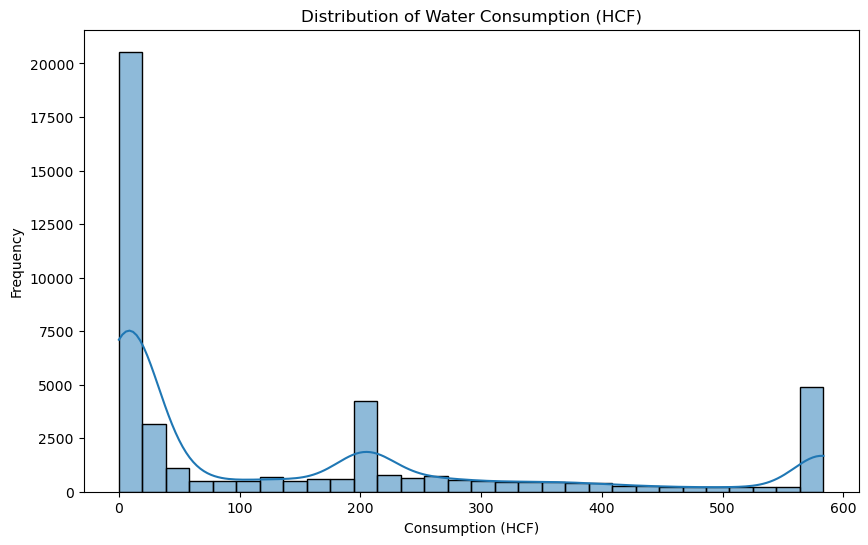

In [19]:
## Histogram of Water Consumption
plt.figure(figsize=(10, 6))
sns.histplot(data['Consumption (HCF)'], bins=30, kde=True)
plt.title('Distribution of Water Consumption (HCF)')
plt.xlabel('Consumption (HCF)')
plt.ylabel('Frequency')
plt.show()
#Check for normal distribution

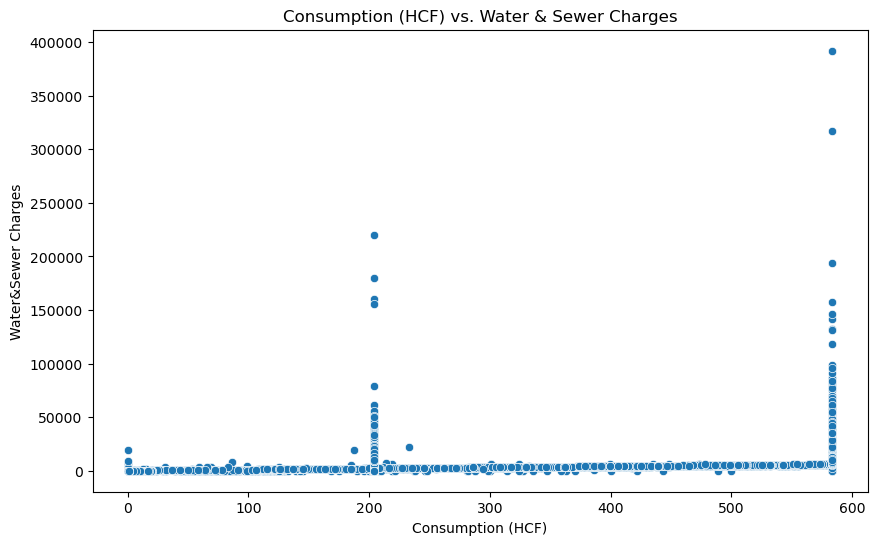

In [20]:
# Scatter Plot of Consumption vs. Charges
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Consumption (HCF)', y='Water&Sewer Charges', data=data)
plt.title('Consumption (HCF) vs. Water & Sewer Charges')
plt.xlabel('Consumption (HCF)')
plt.ylabel('Water&Sewer Charges')
plt.show()
#check for correlation

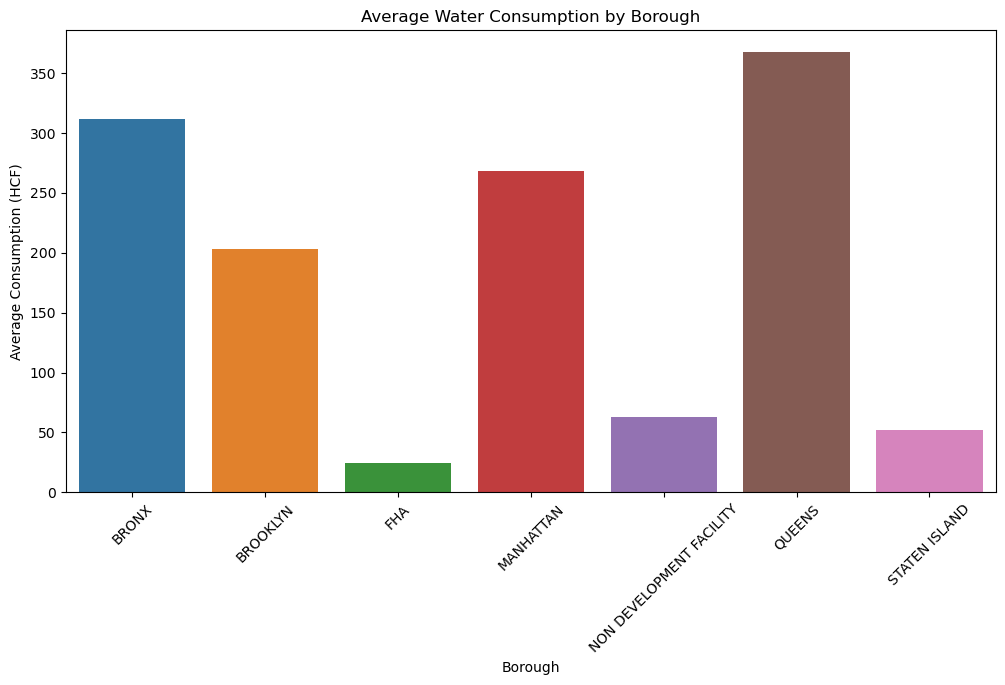

In [21]:
# Bar Chart of Average Consumption by Borough
plt.figure(figsize=(12, 6))
sns.barplot(x='Borough', y='Consumption (HCF)', data=data.groupby('Borough')['Consumption (HCF)'].mean().reset_index())
plt.title('Average Water Consumption by Borough')
plt.xlabel('Borough')
plt.ylabel('Average Consumption (HCF)')
plt.xticks(rotation=45)
plt.show()
#check for categorical distribution

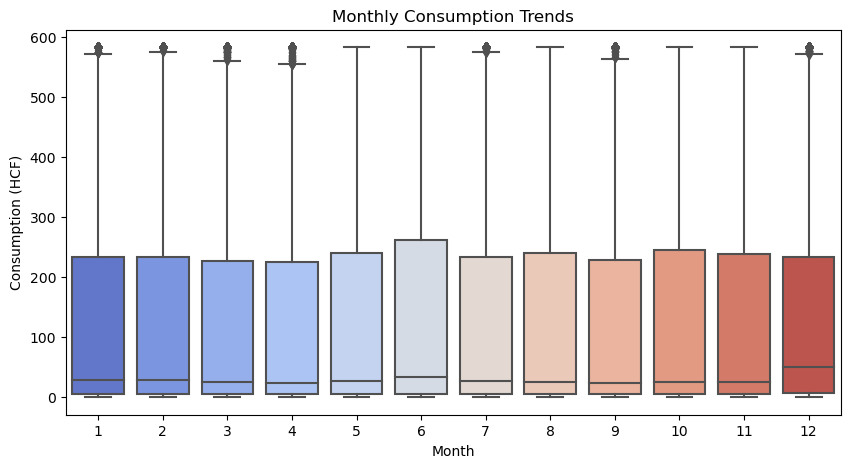

In [22]:
# Monthly Consumption Trends
data['Month'] = data['Service Start Date'].dt.month
plt.figure(figsize=(10, 5))
sns.boxplot(x="Month", y="Consumption (HCF)", data=data, palette="coolwarm")
plt.title("Monthly Consumption Trends")
plt.xlabel("Month")
plt.ylabel("Consumption (HCF)")
plt.show()

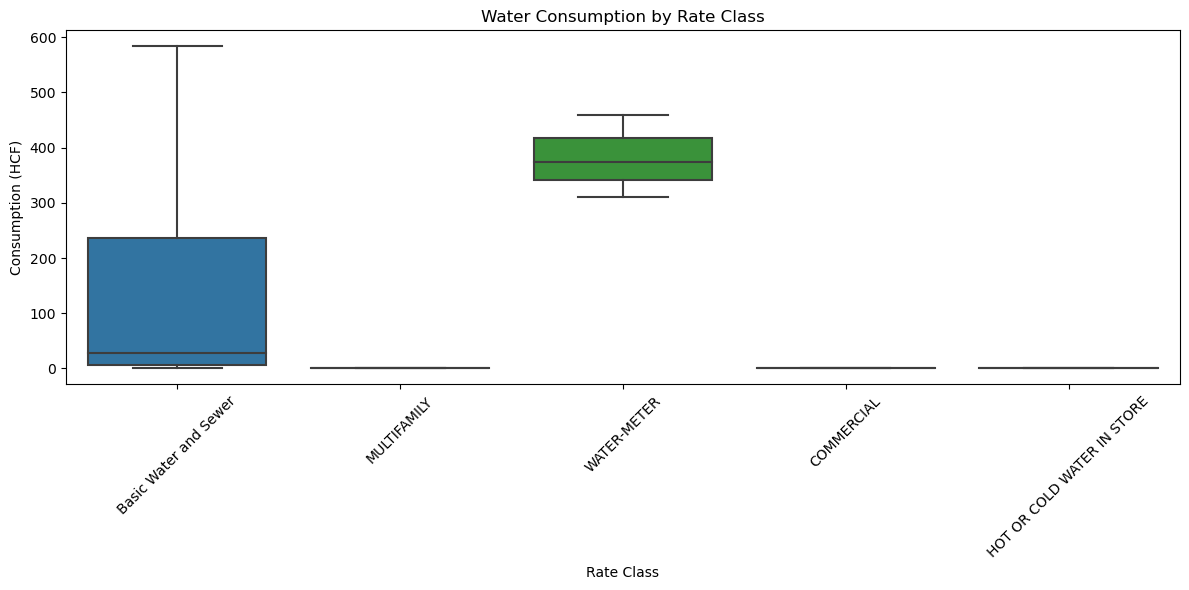

In [23]:
# Box Plot of Consumption by Rate Class
plt.figure(figsize=(12, 6))
sns.boxplot(x='Rate Class', y='Consumption (HCF)', data=data)
plt.title('Water Consumption by Rate Class')
plt.xlabel('Rate Class')
plt.ylabel('Consumption (HCF)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# check for outlier and categorical impact

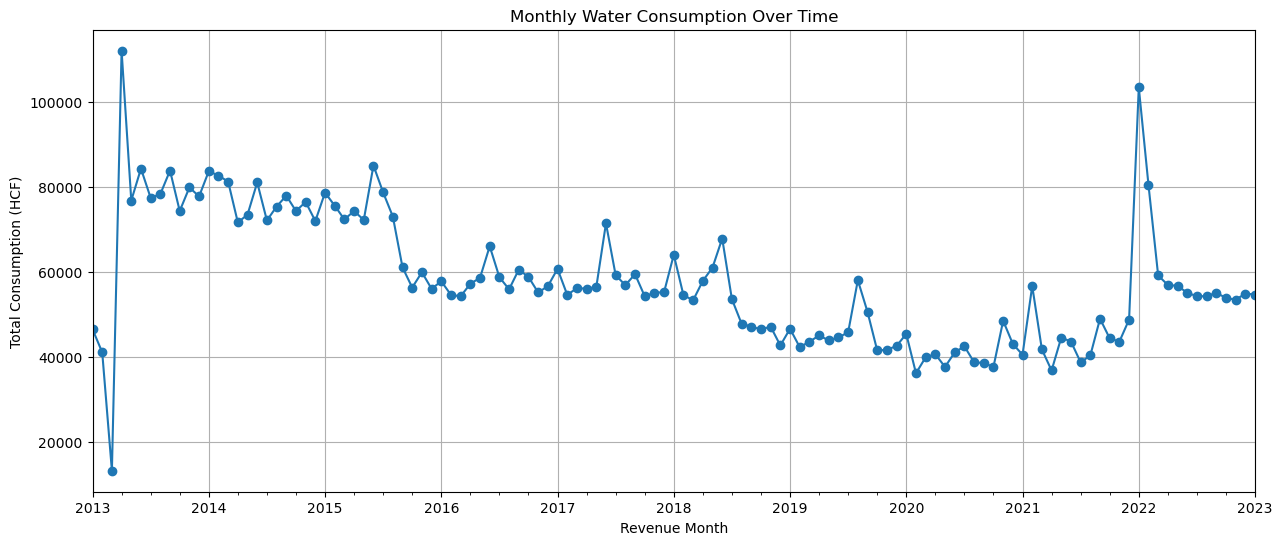

In [24]:
# Time Series Plot of Total Consumption Over Time
monthly_consumption = data.groupby('Revenue Month')['Consumption (HCF)'].sum()
plt.figure(figsize=(15, 6))
monthly_consumption.plot(marker='o')
plt.title('Monthly Water Consumption Over Time')
plt.xlabel('Revenue Month')
plt.ylabel('Total Consumption (HCF)')
plt.grid(True)
plt.show()
#check for outliers and anomlies with time series data

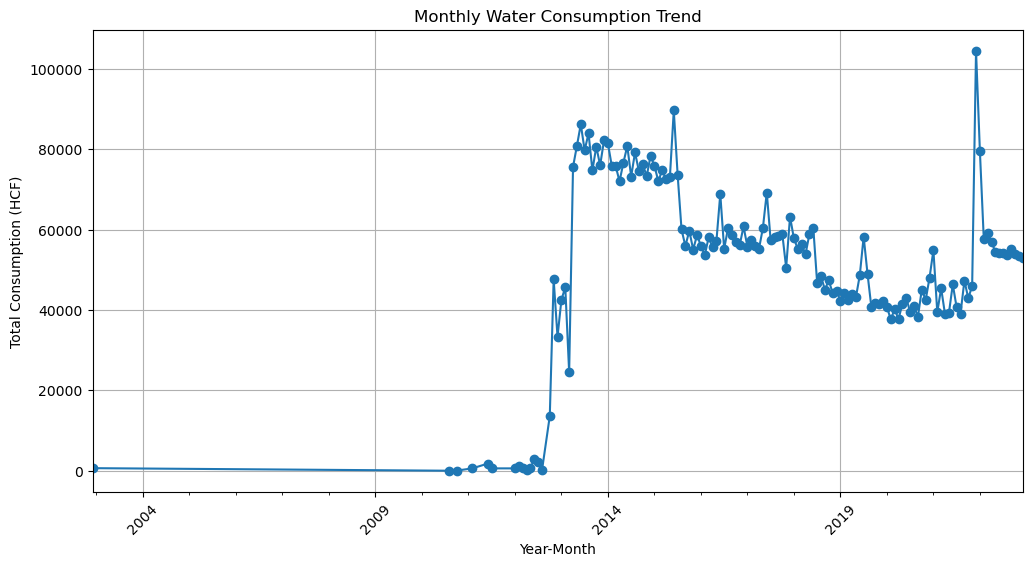

In [25]:
# Analyzing how water consumption changes over time.
data['Service Start Date'] = pd.to_datetime(data['Service Start Date'])
data['Year-Month'] = data['Service Start Date'].dt.to_period('M')

plt.figure(figsize=(12, 6))
data.groupby('Year-Month')['Consumption (HCF)'].sum().plot(kind='line', marker='o')
plt.title("Monthly Water Consumption Trend")
plt.xlabel("Year-Month")
plt.ylabel("Total Consumption (HCF)")
plt.xticks(rotation=45)
plt.grid()
plt.show()

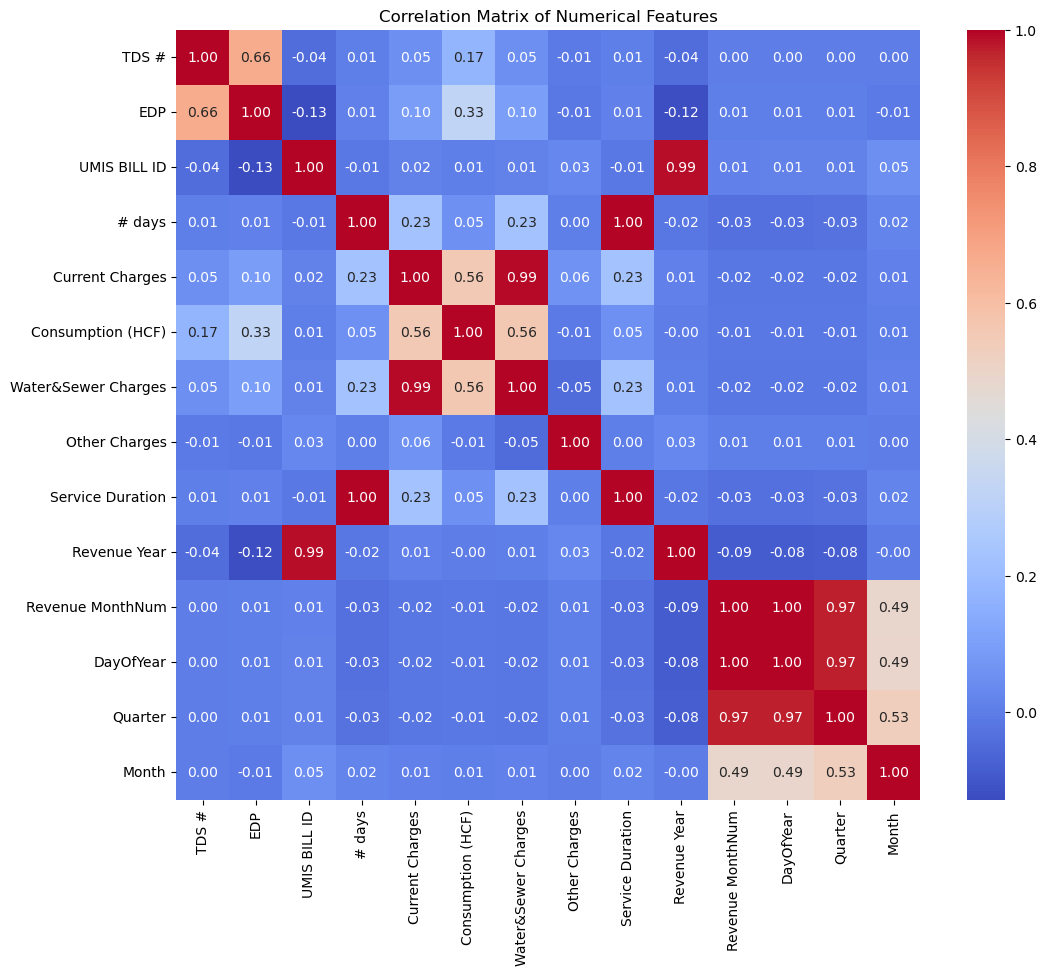

In [26]:
# Heatmap of Correlation Matrix
numeric_data = data.select_dtypes(include=np.number) #numerical columns
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()
#check for multicolinearity

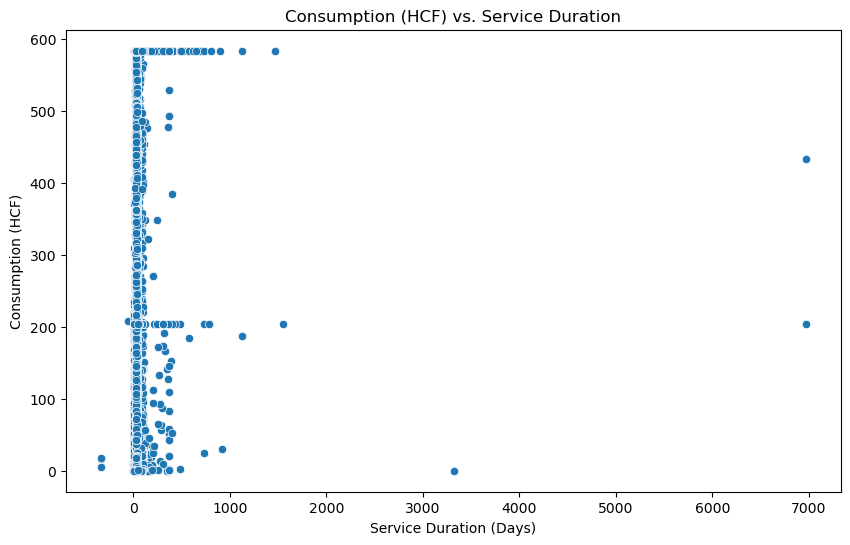

In [27]:
# Consumption vs. Service Duration
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Service Duration', y='Consumption (HCF)', data=data)
plt.title('Consumption (HCF) vs. Service Duration')
plt.xlabel('Service Duration (Days)')
plt.ylabel('Consumption (HCF)')
plt.show()
#check relationship between service duration and consumption

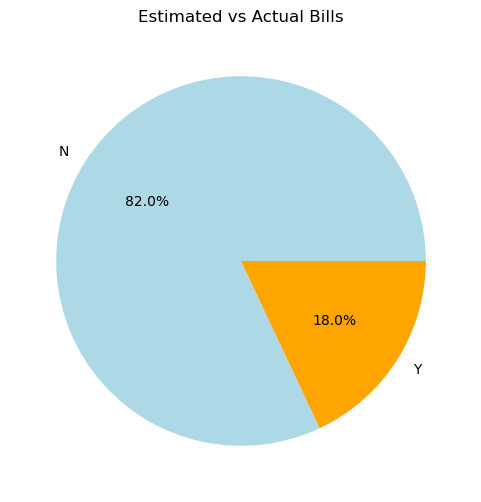

In [28]:
#Estimated Bills Distribution
plt.figure(figsize=(6, 6))
data['Estimated'].value_counts().plot.pie(autopct='%1.1f%%', colors=["lightblue", "orange"])
plt.title("Estimated vs Actual Bills")
plt.ylabel("")
plt.show()

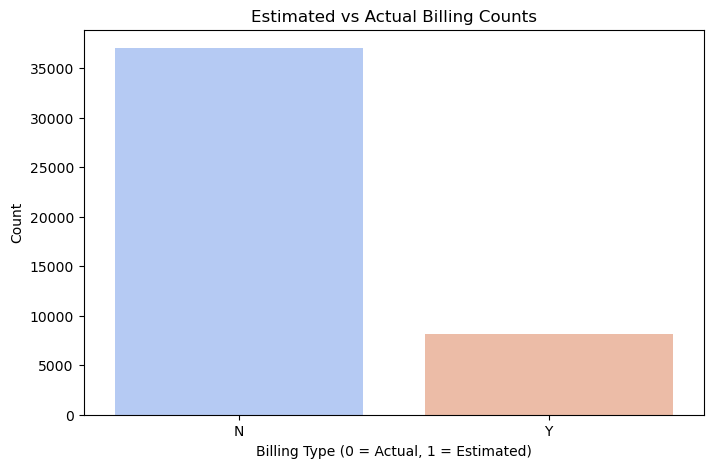

In [29]:
#Compares estimated vs actual readings
plt.figure(figsize=(8, 5))
sns.countplot(x='Estimated', data=data, palette='coolwarm')
plt.title("Estimated vs Actual Billing Counts")
plt.xlabel("Billing Type (0 = Actual, 1 = Estimated)")
plt.ylabel("Count")
plt.show()

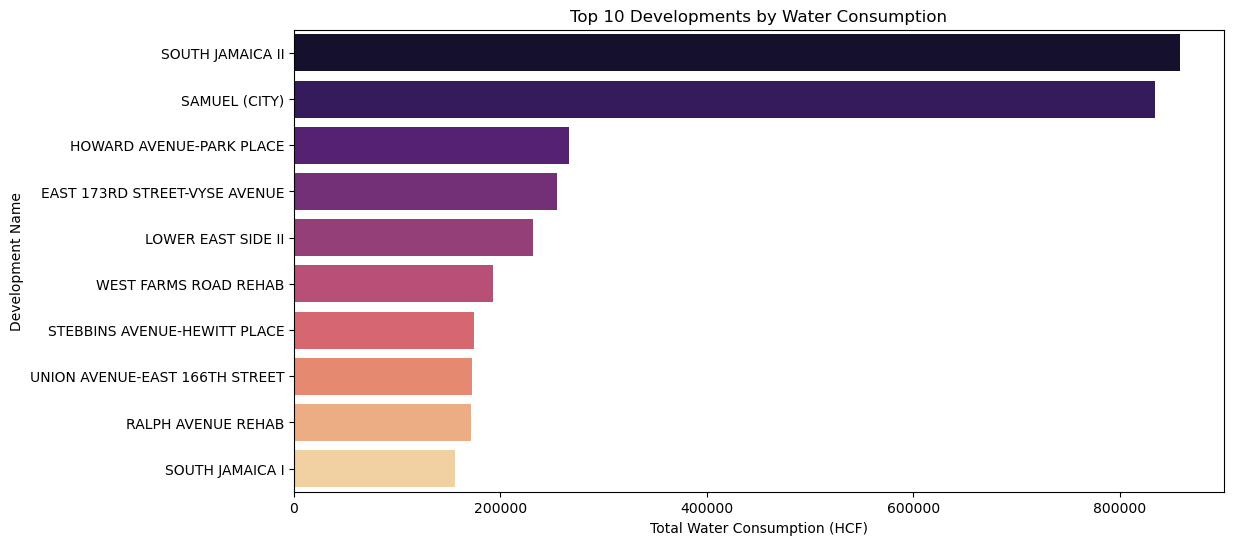

In [30]:
#Identifies the buildings with the highest water consumption.
top_10 = data.groupby("Development Name")["Consumption (HCF)"].sum().nlargest(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10.values, y=top_10.index, palette="magma")
plt.title("Top 10 Developments by Water Consumption")
plt.xlabel("Total Water Consumption (HCF)")
plt.ylabel("Development Name")
plt.show()

In [31]:
numerical_features = ['TDS #', '# days', 'Current Charges', 'Water&Sewer Charges', 'Other Charges', 'Service Duration', 'Revenue Year', 'Revenue MonthNum', 'DayOfYear', 'Quarter']
categorical_features = ['Borough', 'Account Name', 'Rate Class', 'Season', 'Month']


In [32]:
#X = data[numerical_features + categorical_features]
#y = data['Consumption (HCF)']  # Make sure this column exists in your data


In [33]:
# Create transformers - things that change the data
# Impute missing numerical data with the mean and scale it
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Fill missing values with the average
    ('scaler', StandardScaler()) # Make sure all numerical features have a similar scale
])


In [34]:
# Impute missing categorical data with the most frequent value and one-hot encode it
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Fill missing values with the most common value
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Convert categories into numbers
])

In [35]:
# Combine the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [36]:
# Split data into training and testing sets
X = data.drop(['Consumption (HCF)'], axis=1)  # Features (everything except target)
y = data['Consumption (HCF)'] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training, 20% testing


In [37]:
# Create the pipelines
pipeline_linear = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', LinearRegression())])

pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', RandomForestRegressor(random_state=42))])

pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', GradientBoostingRegressor(random_state=42))])

pipeline_svm = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', SVR())])

In [38]:
# Define parameter grids for hyperparameter tuning - finding the BEST settings for each model
param_grid_linear = {
    'model__fit_intercept': [True, False],  # Whether to include an intercept
    'model__positive': [True, False]       # Force positive coefficients
}
param_grid_rf = {'model__n_estimators': [100, 200], 'model__max_depth': [5, 10]} #  Try different numbers of trees and tree depths. Note 'model__' prefix!
param_grid_gb = {'model__n_estimators': [100, 200], 'model__learning_rate': [0.01, 0.1]} # Try different numbers of trees and learning rates. Note 'model__' prefix!

param_grid_svm = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['rbf', 'linear'],
    'model__gamma': ['scale', 'auto']
}


In [39]:
# Use GridSearchCV to find the best hyperparameters
grid_search_linear = GridSearchCV(pipeline_linear, param_grid_linear, cv=3, scoring='r2')
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='r2')
grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=3, scoring='r2')
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=3, scoring='r2')

In [40]:
grid_search_linear.fit(X_train, y_train) # Train with different settings
grid_search_rf.fit(X_train, y_train)
grid_search_gb.fit(X_train, y_train)
grid_search_svm.fit(X_train, y_train)

/Users/ravallikakadiyala/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
6 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ravallikakadiyala/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ravallikakadiyala/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ravallikakadiyala/anaconda3/lib/python3.11/

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['TDS '
                                                                          '#',
                                                                          '# '
                                                                          'days',
                                                                          'Current '
                                                                          'Charges',
                                                                          'Water&Sewer '
                                                                          'Charges',
                                                                          'Other '
                                                                          'Charges',
                                                                          'Service '
                                                                          'Duration',
                                                                          'Revenue '
                                                                          'Year',
                                                                          'Revenue '
                                                                          'MonthNum',
                                                                          'DayOfYear',
                                                                          'Quarter']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Borough',
                                                                          'Account '
                                                                          'Name',
                                                                          'Rate '
                                                                          'Class',
                                                                          'Season',
                                                                          'Month'])])),
                                       ('model', SVR())]),
             param_grid={'model__C': [0.1, 1, 10],
                         'model__gamma': ['scale', 'auto'],
                         'model__kernel': ['rbf', 'linear']},
             scoring='r2')

In [42]:
# Get the best models
best_linear = grid_search_linear.best_estimator_
best_rf = grid_search_rf.best_estimator_
best_gb = grid_search_gb.best_estimator_
best_svm = grid_search_svm.best_estimator_

In [43]:
# Define a function to plot regression results
def plot_regression_results(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    sns.regplot(x=y_true, y=y_pred, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.show()

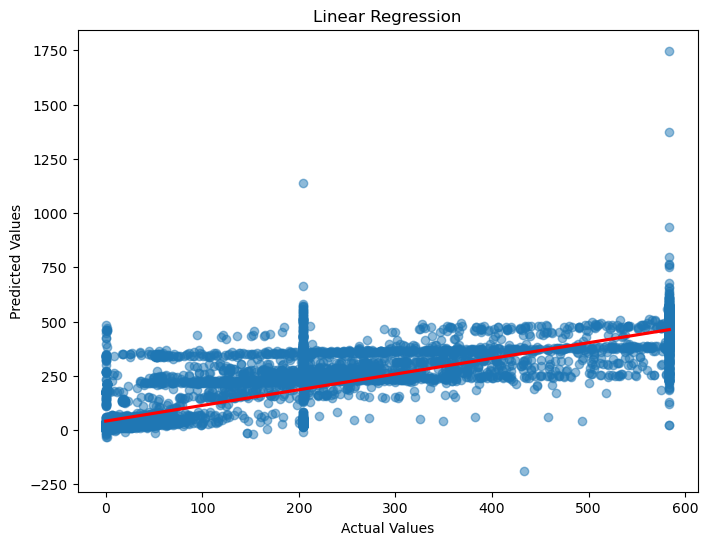

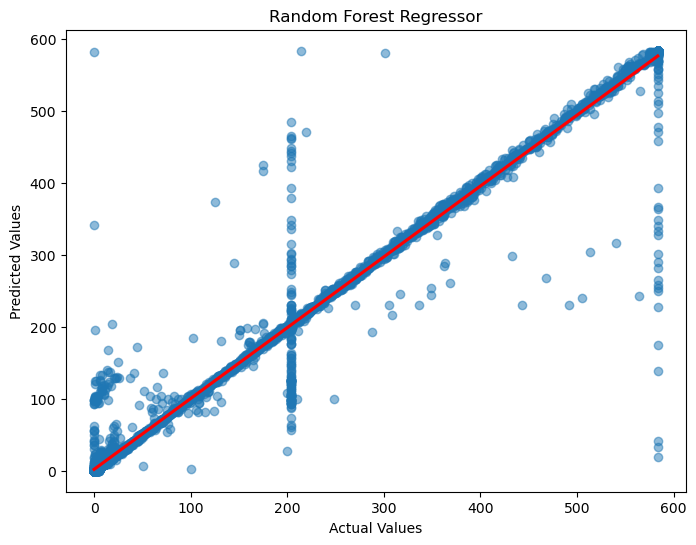

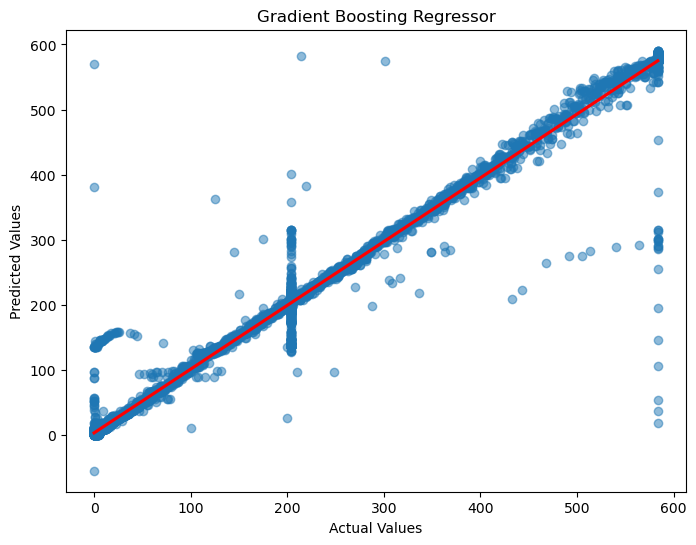

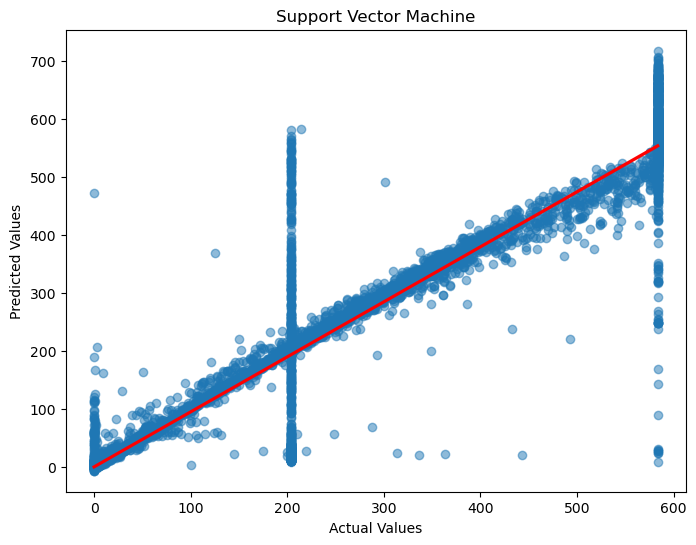

In [44]:
# Evaluate the models
y_pred_lr = best_linear.predict(X_test) # Make predictions on the test set
plot_regression_results(y_test, y_pred_lr, "Linear Regression")

y_pred_rf = best_rf.predict(X_test)
plot_regression_results(y_test, y_pred_rf, "Random Forest Regressor")

y_pred_gb = best_gb.predict(X_test)
plot_regression_results(y_test, y_pred_gb, "Gradient Boosting Regressor")

y_pred_svm = best_svm.predict(X_test)
plot_regression_results(y_test, y_pred_svm, "Support Vector Machine")

In [45]:
# Calculate R-squared, MSE, and MAE
r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

r2_gb = r2_score(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)

r2_svm = r2_score(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)
mae_svm = mean_absolute_error(y_test, y_pred_svm)

In [53]:
print("\nRandom Forest Results:")
print(f"R-squared: {r2_rf:.3f}")
print(f"Mean Squared Error: {mse_rf:.3f}")
print(f"Mean Absolute Error: {mae_rf:.3f}")

print("\nGradient Boosting Results:")
print(f"R-squared: {r2_gb:.3f}")
print(f"Mean Squared Error: {mse_gb:.3f}")
print(f"Mean Absolute Error: {mae_gb:.3f}")

print("\nSupport Vector Machine Results:")
print(f"R-squared: {r2_svm:.3f}")
print(f"Mean Squared Error: {mse_svm:.3f}")
print(f"Mean Absolute Error: {mae_svm:.3f}")

print("\nLinear Regression Results:")
print(f"R-squared: {r2_lr:.3f}")
print(f"Mean Squared Error: {mse_lr:.3f}")
print(f"Mean Absolute Error: {mae_lr:.3f}")


Random Forest Results:
R-squared: 0.982
Mean Squared Error: 708.090
Mean Absolute Error: 5.069

Gradient Boosting Results:
R-squared: 0.983
Mean Squared Error: 653.342
Mean Absolute Error: 6.523

Support Vector Machine Results:
R-squared: 0.905
Mean Squared Error: 3687.852
Mean Absolute Error: 24.480

Linear Regression Results:
R-squared: 0.735
Mean Squared Error: 10329.174
Mean Absolute Error: 64.792


In [47]:
# Compare Models
models = {
    'Ridge Regression': (mse_lr, r2_lr),
    'Random Forest': (mse_rf, r2_rf),
    'Gradient Boosting': (mse_gb, r2_gb),
    'SVR': (mse_svm, r2_svm)
}

In [48]:
best_model = min(models, key=lambda x: models[x][0])
print(f"The best performing model is: {best_model}")
print(f"With MSE: {models[best_model][0]:.2f} and R-squared: {models[best_model][1]:.2f}")

The best performing model is: Gradient Boosting
With MSE: 653.34 and R-squared: 0.98


In [49]:
data.to_csv("Water_Consumption_And_Cost__2013_-_Feb_2023_.csv", index=False)

In [50]:
import pickle

# Save Ridge model
filename = 'linear_regression_model.pkl'
pickle.dump(best_linear, open(filename, 'wb'))

# Save Random Forest model
filename = 'random_forest_model.pkl'
pickle.dump(best_rf, open(filename, 'wb'))

# Save Gradient Boosting model
filename = 'gradient_boosting_model.pkl'
pickle.dump(best_gb, open(filename, 'wb'))

# Save SVM model
filename = 'svm_model.pkl'
pickle.dump(best_svm, open(filename, 'wb'))

print("All models saved to pickle files.")


All models saved to pickle files.
